In [ ]:
#hide
from fastbook import *

In [2]:
#hide
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2),
                          title=same_breed, ctx=ctx)

def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}

    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)

    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]),same

splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [3]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [4]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    img1,img2,same_breed = self
    if not isinstance(img1, Tensor):
      if img2.size != img1.size: img2 = img2.resize(img1.size)
      t1,t2 = tensor(img1),tensor(img2)
      t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
    else: t1,t2 = img1,img2
    line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
    return show_image(torch.cat([t1,line,t2], dim=2),title=same_breed, ctx=ctx)

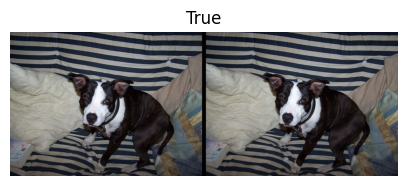

In [5]:
img = PILImage.create(files[8])
s = SiameseImage((img,img, True))
s.show();

In [6]:
Resize(224)(s)

(PILImage mode=RGB size=224x224, PILImage mode=RGB size=224x224, True)

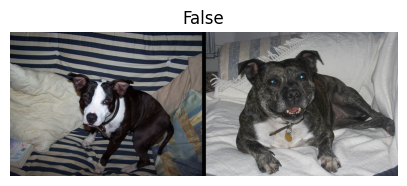

In [7]:
img1 = PILImage.create(files[0])
s1 = SiameseImage((img, img1, False))
s1.show();

In [8]:
def label_func(fname):
  return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [9]:


class SiameseTransform(Transform):
  def __init__(self, files, label_func, splits):
    self.labels = files.map(label_func).unique()
    self.lbl2files = {l: L(f for f in files if label_func(f) == l)
                      for l in self.labels}
    self.label_func = label_func
    self.valid = {f: self._draw(f) for f in files[splits[1]]}

  def encodes(self, f):
    f2,t = self.valid.get(f, self._draw(f))
    img1,img2 = PILImage.create(f),PILImage.create(f2)
    return SiameseImage(img1, img2, t)

  def _draw(self, f):
    same = random.random() < 0.5
    cls = self.label_func(f)
    if not same:
      cls = random.choice(L(l for l in self.labels if l != cls))
    return random.choice(self.lbl2files[cls]),same

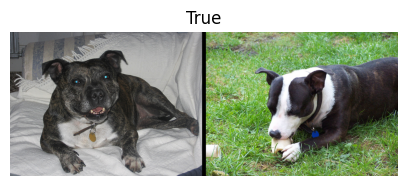

In [10]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

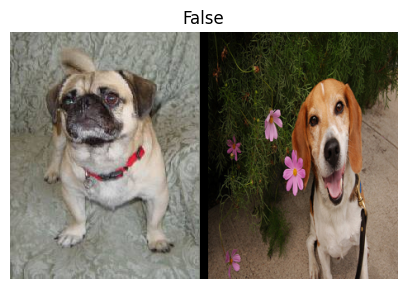

In [11]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [12]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [13]:
class SiameseModel(Module):
  def __init__(self, encoder, head):
    self.encoder,self.head = encoder,head
  def forward(self, x1, x2):
    ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
    return self.head(ftrs)

In [14]:
#encoder = create_body(resnet34(), cut=-2) # worked in old version of fastai/torchvision
encoder = create_body(resnet34(weights=ResNet34_Weights.IMAGENET1K_V1), cut=-2) # update for new torchvision

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 127MB/s]


In [15]:
head = create_head(512*2, 2, ps=0.5)

In [16]:
model = SiameseModel(encoder, head)

In [17]:
def loss_func(out, targ):
  return nn.CrossEntropyLoss()(out, targ.long())

In [18]:
def siamese_splitter(model):
  return [params(model.encoder), params(model.head)]

In [19]:
learn = Learner(dls, model, loss_func=loss_func,
  splitter=siamese_splitter, metrics=accuracy)
learn.freeze()

In [20]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.546314,0.366357,0.848444,01:28
1,0.386001,0.234720,0.914073,01:27
2,0.296249,0.171163,0.938430,01:28
3,0.253075,0.163017,0.943166,01:28


In [21]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.226327,0.163903,0.941813,01:34
1,0.226895,0.157290,0.943166,01:34
2,0.228378,0.151554,0.945196,01:35
3,0.216030,0.151266,0.943843,01:35
